### Notebook for the label transfer of Healthy Human Reference to mouse ACM heart (merged Pkp2+Ttn dataset) using `scANVI`

#### Environment: scANVI

- **Developed by:** Carlos Talavera-López Ph.D
- **Modified by:** Alexandra Cirnu
- **Würzburg Institute for Systems Immunology & Julius-Maximilian-Universität Würzburg**
- **Date of creation:** 230918
- **Date of modification:** 240502

#### Transfer the **lypmphoids** from Healthy Human cell atlas to **lymphoids** of ACM Ctr noninf mice (Pkp2 + Ttn)

### Import required modules

In [1]:
import scvi
import torch
import anndata
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import plotnine as p
from pywaffle import Waffle
import matplotlib.pyplot as plt
from scib_metrics.benchmark import Benchmarker
import muon as mu
from muon import atac as ac
from muon import prot as pt
from scipy.sparse import csr_matrix

### Set up working environment

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 180, color_map = 'magma_r', dpi_save = 300, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                 10.2.0
absl                NA
asttokens           NA
attr                23.2.0
chex                0.1.85
colorama            0.4.6
comm                0.2.1
contextlib2         NA
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
docrep              0.3.2
etils               1.7.0
exceptiongroup      1.2.0
executing           2.0.1
flax                0.8.1
fsspec              2024.2.0
h5py                3.10.0
igraph              0.11.4
importlib_resources NA
ipykernel           6.29.3
ipywidgets          8.1.2
jax                 0.4.25
jaxlib              0.4.25
jedi                0.19.1
joblib              1.3.2
kiwisolver          1.4.5
lightning           2.1.4
lightning_utilities 0.10.1
llvmlite            0.42.0
matplotlib          3.8.3
mizani              0.11.0
ml_collections      NA
ml_dtypes           0.3.2
mpl_toolkit

In [3]:
def X_is_raw(adata): return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

In [4]:
torch.set_float32_matmul_precision('high')

In [5]:
warnings.simplefilter(action = 'ignore')
scvi.settings.seed = 1712
%config InlineBackend.print_figure_kwargs = {'facecolor' : "w"}
%config InlineBackend.figure_format = 'retina'

Seed set to 1712


In [6]:
arches_params = dict(
    use_layer_norm = "both",
    use_batch_norm = "none",
    encode_covariates = True,
    dropout_rate = 0.2,
    n_layers = 2,
)

### Read in Healthy data

In [7]:
# Data set with lineage information from Healthy human heart leucocytes (from Human cell atlas) 

reference = sc.read_h5ad('/home/acirnu/data/ACM_cardiac_leuco/Reference_data/HCA_lymphoids_healthy_reference_ac240319.raw.h5ad')
reference

AnnData object with n_obs × n_vars = 16403 × 33538
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage'
    uns: 'cell_states_colors', 'scNym_colors', 'scNym_probabilities'
    obsm: 'X_pca', 'X_scnym', 'X_umap'
    layers: 'counts'

In [8]:
X_is_raw(reference)

True

In [9]:
reference.obs

,NRP,cell_source,cell_states,donor,gender,n_counts,n_genes,region,sample,scNym,scNym_confidence,lineage
AAAGTGAAGTCGGCCT-1-H0015_apex,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,724.717285,588,AX,H0015_apex,CD4+T_cell,0.797180,lymphoid
AAATGGAAGGTCCCTG-1-H0015_apex,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,668.059509,515,AX,H0015_apex,CD4+T_cell,0.999248,lymphoid
AAGTTCGCAGTGTATC-1-H0015_apex,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,759.100281,633,AX,H0015_apex,CD4+T_cell,0.979933,lymphoid
AATCACGTCCCGTAAA-1-H0015_apex,No,Harvard-Nuclei,CD8+T_tem,H5,Female,715.088623,604,AX,H0015_apex,CD4+T_cell,0.987953,lymphoid
AATGACCGTGTTGCCG-1-H0015_apex,No,Harvard-Nuclei,NK,H5,Female,743.207153,645,AX,H0015_apex,NK,0.759773,lymphoid
...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCACATCGAACACT-1-HCAHeart8102862,Yes,Sanger-CD45,B_cells,D11,Female,736.678040,1991,AX,HCAHeart8102862,DC,0.999435,lymphoid
TTTCAGTCAGTACTAC-1-HCAHeart8102862,Yes,Sanger-CD45,NKT,D11,Female,774.458374,1108,AX,HCAHeart8102862,NK,0.985920,lymphoid
TTTCGATAGCGCGTTC-1-HCAHeart8102862,Yes,Sanger-CD45,NK,D11,Female,778.039612,1215,AX,HCAHeart8102862,NK,0.984224,lymphoid
TTTGACTGTATGAGAT-1-HCAHeart8102862,Yes,Sanger-CD45,CD8+T_tem,D11,Female,707.116882,957,AX,HCAHeart8102862,CD8+T_cell,0.982434,lymphoid


In [10]:
reference.obs["general_cell_types"] = reference.obs['cell_states'].copy()
reference.obs["general_cell_types"].cat.categories

Index(['NK', 'CD4+T_cytox', 'CD8+T_tem', 'CD8+T_cytox', 'NKT', 'B_cells',
       'CD4+T_tem'],
      dtype='object')

In [11]:
trans_from = [  
              ['NK'],                                                   #NK
              ['CD4+T_cytox', 'CD4+T_tem'],                             #CD4
              ['CD8+T_tem', 'CD8+T_cytox'],                             #CD8
              ['NKT'],                                                  #NKT
              ['B_cells']                                               #B

]

trans_to = ['NK', 'CD4', 'CD8', 'NKT', 'B']

reference.obs['general_cell_types'] = [str(i) for i in reference.obs['cell_states']]
for leiden,celltype in zip(trans_from, trans_to):
    for leiden_from in leiden:
        reference.obs['general_cell_types'][reference.obs['general_cell_types'] == leiden_from] = celltype

In [12]:
reference.obs

,NRP,cell_source,cell_states,donor,gender,n_counts,n_genes,region,sample,scNym,scNym_confidence,lineage,general_cell_types
AAAGTGAAGTCGGCCT-1-H0015_apex,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,724.717285,588,AX,H0015_apex,CD4+T_cell,0.797180,lymphoid,CD4
AAATGGAAGGTCCCTG-1-H0015_apex,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,668.059509,515,AX,H0015_apex,CD4+T_cell,0.999248,lymphoid,CD4
AAGTTCGCAGTGTATC-1-H0015_apex,No,Harvard-Nuclei,CD4+T_cytox,H5,Female,759.100281,633,AX,H0015_apex,CD4+T_cell,0.979933,lymphoid,CD4
AATCACGTCCCGTAAA-1-H0015_apex,No,Harvard-Nuclei,CD8+T_tem,H5,Female,715.088623,604,AX,H0015_apex,CD4+T_cell,0.987953,lymphoid,CD8
AATGACCGTGTTGCCG-1-H0015_apex,No,Harvard-Nuclei,NK,H5,Female,743.207153,645,AX,H0015_apex,NK,0.759773,lymphoid,NK
...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTCACATCGAACACT-1-HCAHeart8102862,Yes,Sanger-CD45,B_cells,D11,Female,736.678040,1991,AX,HCAHeart8102862,DC,0.999435,lymphoid,B
TTTCAGTCAGTACTAC-1-HCAHeart8102862,Yes,Sanger-CD45,NKT,D11,Female,774.458374,1108,AX,HCAHeart8102862,NK,0.985920,lymphoid,NKT
TTTCGATAGCGCGTTC-1-HCAHeart8102862,Yes,Sanger-CD45,NK,D11,Female,778.039612,1215,AX,HCAHeart8102862,NK,0.984224,lymphoid,NK
TTTGACTGTATGAGAT-1-HCAHeart8102862,Yes,Sanger-CD45,CD8+T_tem,D11,Female,707.116882,957,AX,HCAHeart8102862,CD8+T_cell,0.982434,lymphoid,CD8


In [13]:
reference.obs['seed_labels'] = reference.obs['general_cell_types'].copy()

In [14]:
reference.obs['seed_labels'].value_counts() 

seed_labels
CD8    5957
CD4    4160
NK     3628
NKT    1463
B      1195
Name: count, dtype: int64

### Subset populations of interest

In [15]:
reference = reference[~reference.obs['seed_labels'].isin(['nan'])]              # = filter out not assigned cells, keep everything that is not 'nan'
reference.obs['seed_labels'].value_counts()

seed_labels
CD8    5957
CD4    4160
NK     3628
NKT    1463
B      1195
Name: count, dtype: int64

In [16]:
sc.pp.filter_cells(reference, min_genes = 200)            
sc.pp.filter_cells(reference, min_counts = 100)

### Read in query

In [17]:
mdata = mu.read_h5mu('/home/acirnu/data/ACM_cardiac_leuco/4_Seed_labeling_with_scANVI/ACM_scANVI_extracted_lymphoids_from_HCA_muon_ac240409.raw.h5mu')
mdata

MuData object with n_obs × n_vars = 10104 × 29477
  var:	'gene_ids', 'feature_types'
  2 modalities
    rna:	10104 x 29378
      obs:	'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
      var:	'gene_ids', 'feature_types', 'mt', 'ribo'
      obsm:	'X_scANVI', 'X_scVI', 'X_umap'
    prot:	10104 x 99
      obs:	'library', 'batch'
      var:	'gene_ids', 'feature_types'
      uns:	'neighbors', 'pca', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'counts', 'log_norm'

In [18]:
#Merged Pkp2+Ttn Libraries subsetted to contain only control mice (Pkp_Ctr_noninf and Ttn_Ctr_noninf)
query = mdata.mod['rna']
query.obs['cell_source'] = 'AG_Gerull'
query.obs['seed_labels'] = 'Unknown'
query.obs['donor'] = query.obs['sample'].copy()
query

AnnData object with n_obs × n_vars = 10104 × 29378
    obs: 'cell_source', 'donor', 'n_counts', 'sample', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', 'batch', '_scvi_batch', '_scvi_labels', 'C_scANVI'
    var: 'gene_ids', 'feature_types', 'mt', 'ribo'
    obsm: 'X_scANVI', 'X_scVI', 'X_umap'

In [19]:
query = query[query.obs['condition'].isin(["Pkp2_Ctr_noninf", "Ttn_Ctr_noninf"]) , :]
del(query.obs['batch'])
query.obs

,cell_source,donor,n_counts,sample,seed_labels,condition,genotype,infection,library,model,...,total_counts_ribo,pct_counts_ribo,percent_mt,percent_chrY,XIST-counts,S_score,G2M_score,_scvi_batch,_scvi_labels,C_scANVI
AAACCCAAGATACAGT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,8562.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,2026.0,23.662695,0.019038,0.000000,0.0,-0.339369,-0.496061,7,1,lymphoid
AACCCAATCAGCTGAT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,14129.0,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,3231.0,22.867861,0.019817,0.021233,0.0,0.525671,-0.137837,6,1,lymphoid
AACCTGAAGATAGCAT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_1,14171.0,Pkp2_Ctr_noninf_1,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,3172.0,22.383741,0.016230,0.063510,0.0,-0.268814,-0.516689,6,1,lymphoid
AACGTCAAGCTACTGT-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,2057.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,39.0,1.895965,0.074866,0.194458,0.0,-0.270605,-0.340320,7,1,lymphoid
AACTTCTCAAGCGCTC-1-A1,AG_Gerull,Pkp2_Ctr_noninf_2,9940.0,Pkp2_Ctr_noninf_2,Unknown,Pkp2_Ctr_noninf,Pkp2_Ctr,noninf,A1,Pkp2,...,2949.0,29.668009,0.022233,0.000000,0.0,-0.414867,-0.271517,7,1,lymphoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTTTGTAAGTAGT-1-B2,AG_Gerull,Ttn_Ctr_noninf_2,8900.0,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,1436.0,16.134830,0.031573,0.033708,0.0,-0.518748,-0.153977,24,2,lymphoid
TTGTGGAGTATTGAGA-1-B2,AG_Gerull,Ttn_Ctr_noninf_2,2299.0,Ttn_Ctr_noninf_2,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,67.0,2.914311,0.058286,0.130492,0.0,-0.117061,-0.443566,24,2,lymphoid
TTGTTCAGTGGCAGAT-1-B2,AG_Gerull,Ttn_Ctr_noninf_1,6256.0,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,1839.0,29.395781,0.025575,0.015985,0.0,0.373745,-0.350468,23,2,lymphoid
TTTACTGAGTGTTCCA-1-B2,AG_Gerull,Ttn_Ctr_noninf_1,2371.0,Ttn_Ctr_noninf_1,Unknown,Ttn_Ctr_noninf,Ttn_Ctr,noninf,B2,Ttn,...,52.0,2.193167,0.035428,0.210881,0.0,0.327349,-0.098295,23,2,lymphoid


In [20]:
X_is_raw(query)

True

In [21]:
sc.pp.filter_cells(query, min_genes = 200)
sc.pp.filter_cells(query, min_counts = 100)

### Change gene symbols for label transfer

In [22]:
query.var_names = [gene_name.upper() for gene_name in query.var_names]                      #capitalize gene names to match with the human genes from reference
query.var_names

Index(['XKR4', 'GM1992', 'GM19938', 'GM37381', 'RP1', 'SOX17', 'GM37587',
       'GM37323', 'MRPL15', 'LYPLA1',
       ...
       'VMN2R122', 'IL11RA2-1', 'CCL27A-1', 'CCL21C-1', 'CCL27A-2',
       'IL11RA2-2', 'CCL19-1', 'CCL21A-1', 'GM10931', 'GM16367'],
      dtype='object', length=29378)

### Merge reference and query (make sure the seed_labels of query are 'Unknown')

In [23]:
adata = reference.concatenate(query, batch_key = 'batch', batch_categories = ['reference', 'query'], join = 'inner')                #merge to one adata object
adata

AnnData object with n_obs × n_vars = 17531 × 16194
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query'
    obsm: 'X_umap'

In [24]:
adata.obs['seed_labels'] = adata.obs['seed_labels'].astype('category')
adata.obs['seed_labels'].cat.categories

Index(['B', 'CD4', 'CD8', 'NK', 'NKT', 'Unknown'], dtype='object')

In [25]:
adata.obs['batch'].value_counts()

batch
reference    16403
query         1128
Name: count, dtype: int64

### Select HVGs

In [26]:
adata.obs['donor'] = adata.obs['donor'].astype('str') 
adata.obs['donor'].value_counts()

donor
D6                   4753
D7                   3809
D11                  2049
H2                   1511
H3                    707
H5                    619
H6                    578
H4                    551
H7                    526
D2                    462
D3                    376
Pkp2_Ctr_noninf_2     298
Ttn_Ctr_noninf_1      245
D5                    220
Ttn_Ctr_noninf_2      173
D4                    168
Pkp2_Ctr_noninf_4     163
Pkp2_Ctr_noninf_1     136
Pkp2_Ctr_noninf_3     113
D1                     74
Name: count, dtype: int64

In [27]:
adata_raw = adata.copy()
adata.layers['counts'] = adata.X.copy()

sc.pp.highly_variable_genes(
    adata,
    flavor = "seurat_v3",
    n_top_genes = 7000,
    layer = "counts",
    batch_key = "donor",
    subset = True,
    span = 1
    )

adata

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


AnnData object with n_obs × n_vars = 17531 × 7000
    obs: 'NRP', 'cell_source', 'cell_states', 'donor', 'gender', 'n_counts', 'n_genes', 'region', 'sample', 'scNym', 'scNym_confidence', 'lineage', 'general_cell_types', 'seed_labels', 'condition', 'genotype', 'infection', 'library', 'model', 'n_genes_by_counts', 'total_counts', 'doublet_scores', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'percent_mt', 'percent_chrY', 'XIST-counts', 'S_score', 'G2M_score', '_scvi_batch', '_scvi_labels', 'C_scANVI', 'batch'
    var: 'gene_ids-query', 'feature_types-query', 'mt-query', 'ribo-query', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'
    obsm: 'X_umap'
    layers: 'counts'

### Transfer of annotation with scANVI

In [28]:
scvi.model.SCVI.setup_anndata(adata, 
                              batch_key = 'donor', 
                              labels_key = 'seed_labels',
                              layer = 'counts',
                              categorical_covariate_keys = ['donor', 'cell_source'])

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [29]:
scvi_model = scvi.model.SCVI(adata, 
                             n_latent = 150, 
                             n_layers = 3, 
                             dispersion = 'gene-batch', 
                             gene_likelihood = 'nb')

In [30]:
scvi_model.train(20, 
                 check_val_every_n_epoch = 1, 
                 enable_progress_bar = True,
                 accelerator = "gpu",
                 devices = [1]                                        
                 )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Epoch 20/20: 100%|██████████| 20/20 [00:16<00:00,  1.21it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.85e+3]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 20/20: 100%|██████████| 20/20 [00:16<00:00,  1.18it/s, v_num=1, train_loss_step=1.59e+3, train_loss_epoch=1.85e+3]


### Evaluate model performance a la _Sevensson_

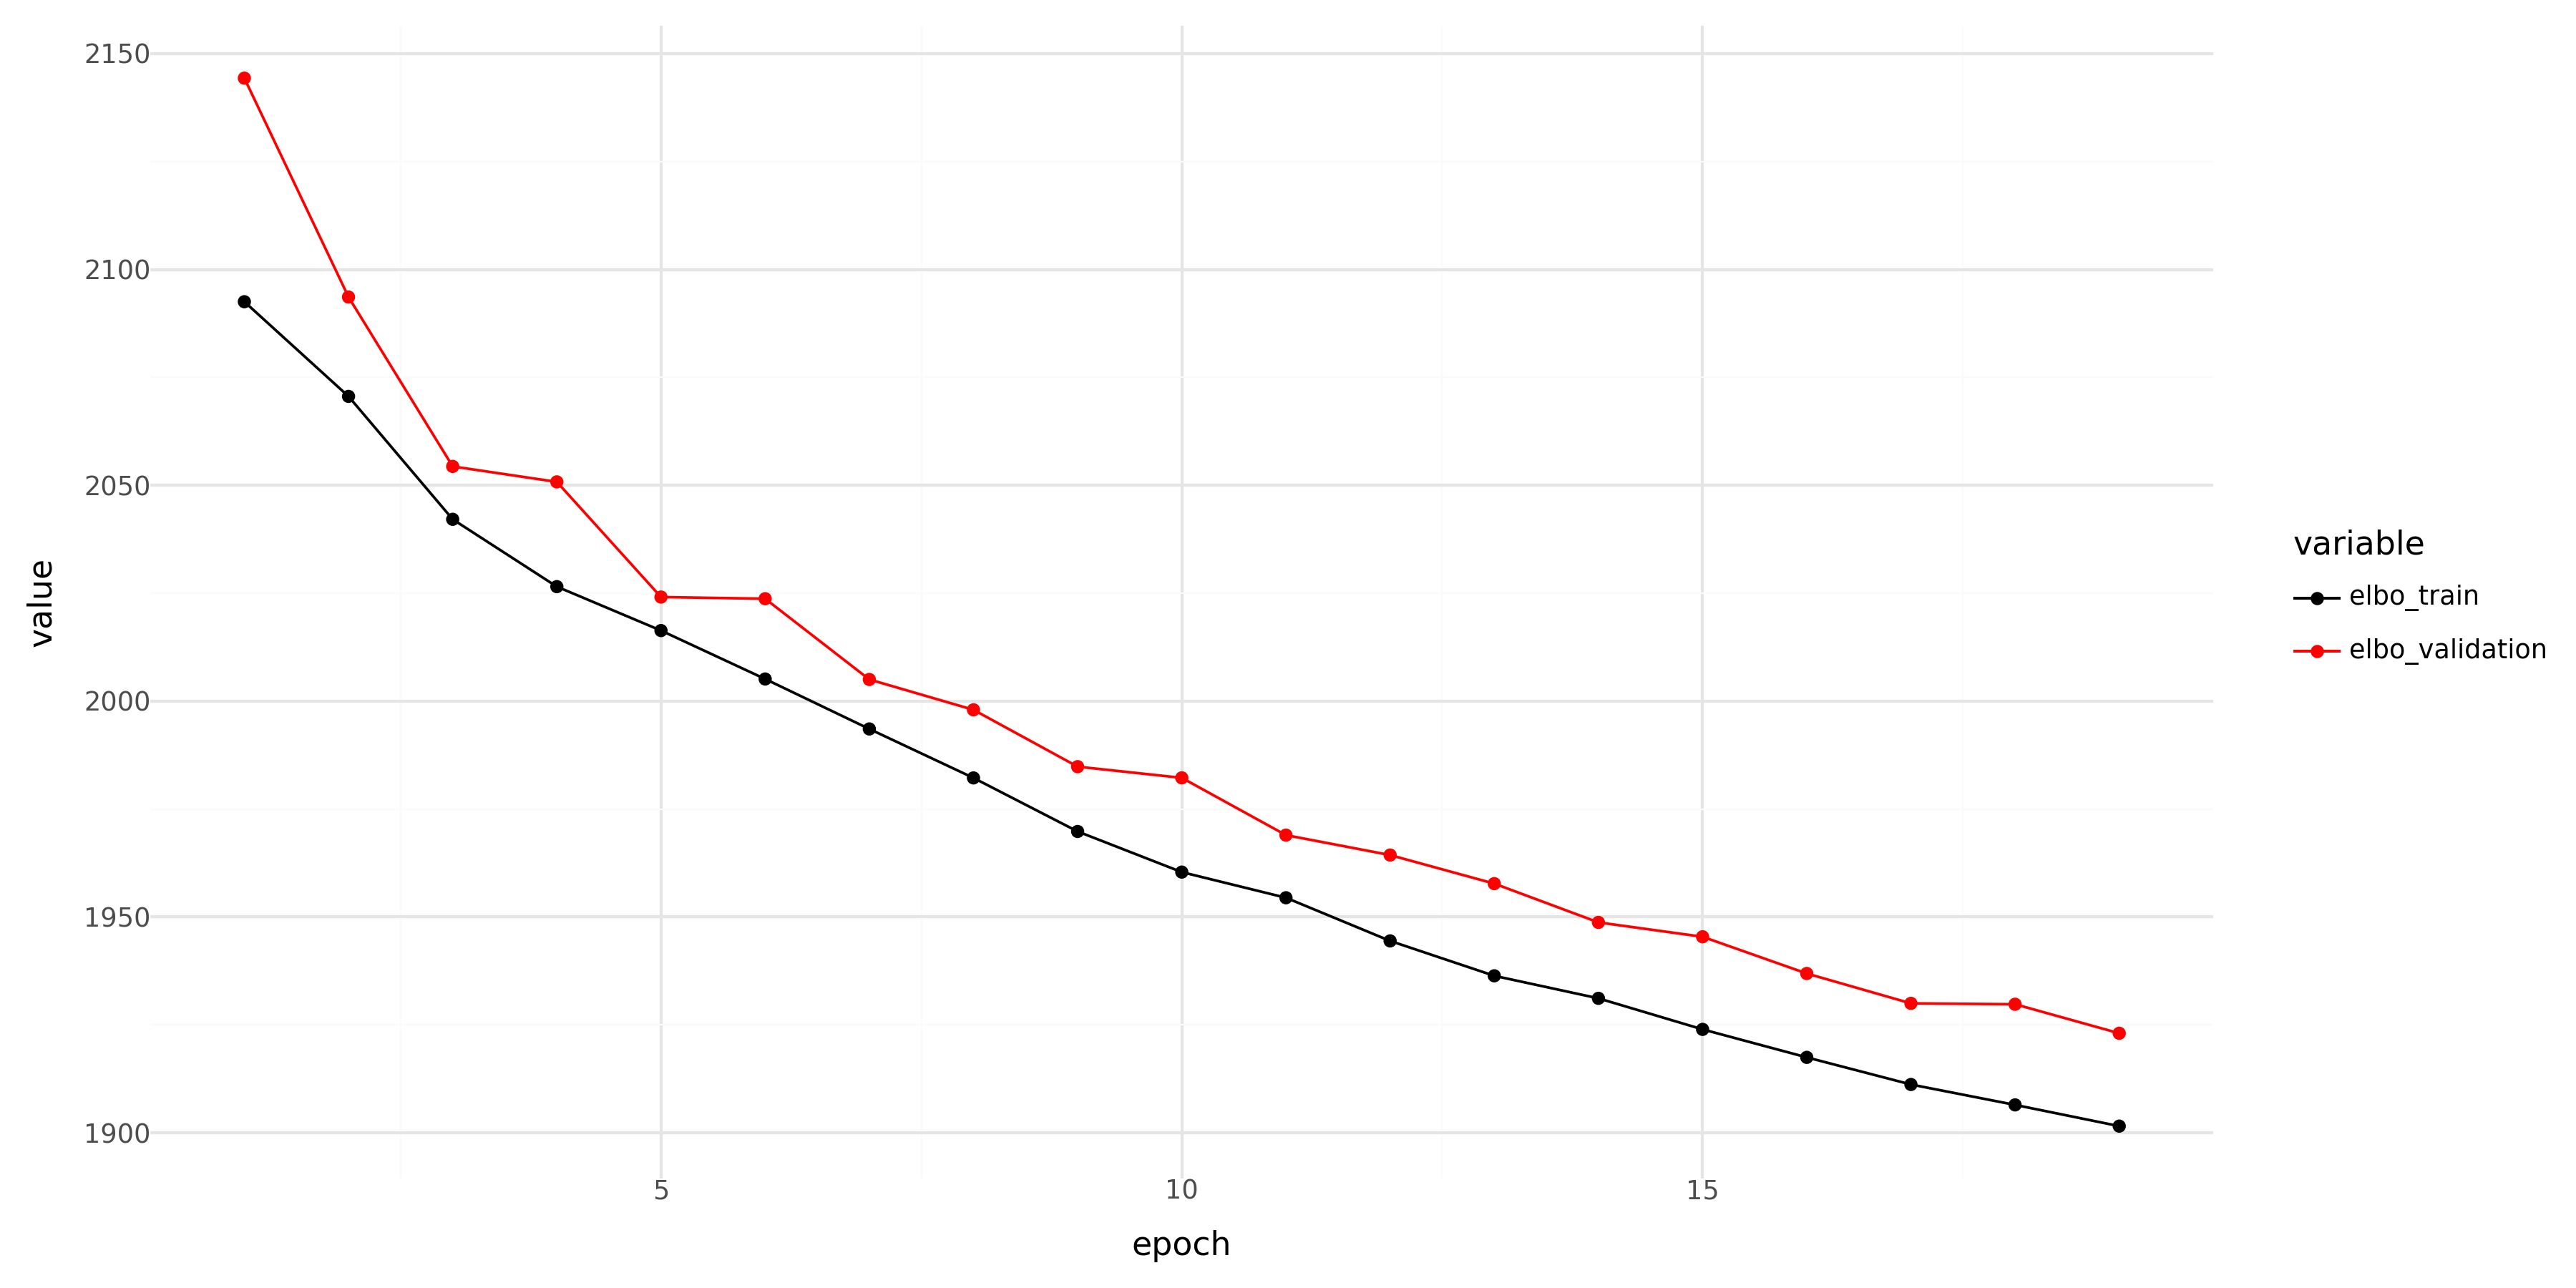

In [31]:
history_df = (
    scvi_model.history['elbo_train'].astype(float)
    .join(scvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig1.png', dpi = 300)

print(p_)

- get latent representation

In [ ]:
adata.obsm["X_scVI"] = scvi_model.get_latent_representation()

### Label transfer with `scANVI` 

In [ ]:
scanvi_model = scvi.model.SCANVI.from_scvi_model(scvi_model, 'Unknown')

In [ ]:
scanvi_model.train(6, 
                   check_val_every_n_epoch = 1, 
                   enable_progress_bar = True,
                   accelerator = "gpu",
                   devices = [1]                            
)

### Evaluate model performance a la Svensson

In [ ]:
history_df = (
    scanvi_model.history['elbo_train'].astype(float)
    .join(scanvi_model.history['elbo_validation'].astype(float))
    .reset_index()
    .melt(id_vars = ['epoch'])
)

p.options.figure_size = 12, 6

p_ = (
    p.ggplot(p.aes(x = 'epoch', y = 'value', color = 'variable'), history_df.query('epoch > 0'))
    + p.geom_line()
    + p.geom_point()
    + p.scale_color_manual({'elbo_train': 'black', 'elbo_validation': 'red'})
    + p.theme_minimal()
)

p_.save('fig2.png', dpi = 300)

print(p_)

In [ ]:
adata.obs["C_scANVI"] = scanvi_model.predict(adata)

- Extract latent representation

In [ ]:
adata.obsm["X_scANVI"] = scanvi_model.get_latent_representation(adata)

In [ ]:
adata.obs

- Visualise corrected dataset

In [ ]:
sc.pp.neighbors(adata, use_rep = "X_scANVI", n_neighbors = 50, metric = 'minkowski')
sc.tl.umap(adata, min_dist = 0.3, spread = 4, random_state = 1712)

In [ ]:
sc.pl.umap(adata, frameon = False, color = ['C_scANVI', 'seed_labels', 'condition', 'batch', 'model'], size = 1, legend_fontsize = 5, ncols = 1)

### Compute `scib-metrics`

In [ ]:
adata

In [ ]:
bm = Benchmarker(
    adata,
    batch_key="donor",
    label_key="seed_labels",                                       
    embedding_obsm_keys=["X_scVI", "X_scANVI", "X_pca"],
    n_jobs=-1,
)
bm.benchmark()

In [ ]:
print(adata.X.dtype)

In [ ]:
bm.plot_results_table(min_max_scale=False)

In [ ]:
df = bm.get_results(min_max_scale=False)
df.transpose()

### Export annotated object

In [ ]:
adata_export_merged = anndata.AnnData(X = adata_raw.X, var = adata_raw.var, obs = adata.obs)            #export a merged AnnData object with raw values from X and raw genes but modified observations
adata_export_merged

In [ ]:
adata_export = adata_export_merged[adata_export_merged.obs['batch'].isin(['query'])]                    #subset merged data set to keep only query
adata_export

### Add new gene symbols

In [ ]:
query_export = anndata.AnnData(X = query.X, var = query.var, obs = adata_export.obs)                    #make sure to store the raw X values and the raw genes together with modified observations
query_export

### Revert gene symbols

In [ ]:
query_export.var_names = [gene_name.capitalize() for gene_name in query_export.var_names]           #restore mouse nomenclature
query_export.var_names

In [ ]:
query_export.obs['C_scANVI'].value_counts()

In [ ]:
query_export

In [ ]:
#Clean up metadata - delete all columns that came from merging with reference data set

del(query_export.obs['cell_states'])
del(query_export.obs['gender'])
del(query_export.obs['NRP'])
del(query_export.obs['region'])
del(query_export.obs['scNym'])
del(query_export.obs['scNym_confidence'])
del(query_export.obs['lineage'])


In [ ]:
query_export.obs

In [ ]:
pd.crosstab(query_export.obs['C_scANVI'], query_export.obs['condition'])

#### Update the mdata object

In [ ]:
mdata.mod['rna'] = query_export
mdata

In [ ]:
mdata.mod['rna'].obs_names

In [ ]:
mdata.mod['prot'].obs_names

In [ ]:
mdata.mod['prot'].obs.index = mdata.mod['prot'].obs.index + '-query'
mdata.mod['prot'].obs

In [ ]:
rna_cells = set(mdata.mod['rna'].obs_names)
mask = mdata.mod['prot'].obs_names.isin(rna_cells)
filtered_prot_export = mdata.mod['prot'][mask]
mdata = mu.MuData({"rna": mdata.mod['rna'], "prot": filtered_prot_export})
mdata

In [ ]:
mdata.write('/home/acirnu/data/ACM_cardiac_leuco/4_Seed_labeling_with_scANVI/Pkp2+Ttn_Ctrls_lymphoids_scANVI_cellstates_from_HCA_lymphoids_ac240414.raw.h5mu')   